In [1]:
# TensorFlow and Keras for model building
import tensorflow as tf
import keras
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import L2
from keras.utils import plot_model

# Other utilities
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score, classification_report
import seaborn as sns
import pandas as pd

In [2]:
IMAGE_SIZE = 299
BATCH_SIZE = 32
CLASSES = 4
EPOCHS = 30

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
"C:/Users/REYES/OneDrive/Desktop/CNN_Projects/DATASETS/AMPALAYA_DS", #Folder name or directory
shuffle=True,
image_size=(IMAGE_SIZE, IMAGE_SIZE),
batch_size=BATCH_SIZE
)

#Calls and Displays class names from dataset
class_names = dataset.class_names
class_names

Found 2000 files belonging to 4 classes.


['Healthy',
 'Nitrogen Deficient',
 'Phosphorus Deficient',
 'Potassium Deficient']

In [4]:
# Function for augmenting images using preprocessing layers
def Crop(image):
    image = keras.layers.RandomCrop(IMAGE_SIZE, IMAGE_SIZE)(image)  # Randomly crop image

    return image

def Rotate(image):
    image = keras.layers.RandomRotation(0.4)(image)  # Randomly rotate image

    return image

def Contrast(image):
    image = keras.layers.RandomContrast(0.2)(image)  # Randomly adjust contrast

    return image

def Flip(image):
    image = keras.layers.RandomFlip("horizontal_and_vertical")(image)  # Randomly flip image

    return image

def Brightness(image):
    image = keras.layers.RandomBrightness([0.1, 0.4])(image)  # Randomly adjust brightness

    return image

# Load and augment the training set
def get_dataset_partitions_tf(ds, train_split=0.7, val_split=0.20, test_split=0.10, shuffle=True, shuffle_size=10000, augment_data=True):
    
    # Get length of dataset
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)  # Shuffle dataset before splitting
    
    # Compute percentage accordingly from dataset size
    train_size = int(train_split * ds_size) 
    val_size = int(val_split * ds_size)
    
    # Split the dataset into training, validation, and test sets
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    if augment_data:
    # Apply augmentation only to the training set
        cropped_train_ds = train_ds.map(lambda x, y: (Crop(x), y), num_parallel_calls=tf.data.AUTOTUNE)
        rotated_train_ds = train_ds.map(lambda x, y: (Rotate(x), y), num_parallel_calls=tf.data.AUTOTUNE)
        contrasted_train_ds = train_ds.map(lambda x, y: (Contrast(x), y), num_parallel_calls=tf.data.AUTOTUNE)
        flipped_train_ds = train_ds.map(lambda x, y: (Flip(x), y), num_parallel_calls=tf.data.AUTOTUNE)
        brightness_train_ds = train_ds.map(lambda x, y: (Brightness(x), y), num_parallel_calls=tf.data.AUTOTUNE)
        
    # Concatenate the original training data with the augmented data
        # train_ds = train_ds.concatenate(cropped_train_ds)
        # train_ds = train_ds.concatenate(rotated_train_ds)
        train_ds = train_ds.concatenate(contrasted_train_ds)
        # train_ds = train_ds.concatenate(flipped_train_ds)
        train_ds = train_ds.concatenate(brightness_train_ds)
    
    return train_ds, val_ds, test_ds

# Assuming you already loaded your dataset into `dataset`
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [5]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [6]:
print(
    len(train_ds),
    len(val_ds),
    len(test_ds)
)

132 12 7


In [21]:
from tensorflow.keras.regularizers import L2

inception_model = keras.Sequential()

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), pooling='avg', classes=4)
predictions = Dense(4, activation='softmax')

for layer in base_model.layers:
    layer.trainable = False

inception_model.add(base_model)
inception_model.add(layers.Flatten())

# Regularization and Dropout
inception_model.add(layers.Dense(512, activation='relu', kernel_regularizer=L2(0.005)))
inception_model.add(layers.BatchNormalization())
inception_model.add(layers.Dropout(0.5))
inception_model.add(layers.Dense(512, activation='relu', kernel_regularizer=L2(0.005)))
inception_model.add(layers.BatchNormalization())

inception_model.add(layers.Dense(256, activation='relu'))
inception_model.add(layers.BatchNormalization())
inception_model.add(layers.Dropout(0.3))
inception_model.add(layers.Dense(128, activation='relu'))

inception_model.add(layers.Dense(64, activation='relu'))
inception_model.add(layers.BatchNormalization())
inception_model.add(layers.Dropout(0.1))
inception_model.add(layers.Dense(32, activation='relu'))

inception_model.add(predictions)

inception_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_15 (Dense)            (None, 512)               1049088   
                                                                 
 batch_normalization_290 (Ba  (None, 512)              2048      
 tchNormalization)                                               
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_16 (Dense)            (None, 512)               262656    
                                                      

In [22]:
# Compile the model with an Adam optimizer and categorical crossentropy loss
inception_model.compile(optimizer=Adam(learning_rate=0.001, decay=0.01), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [23]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

In [17]:
# Train the model on the dataset
history = inception_model.fit(
    train_ds,
    epochs=100,
    validation_data=val_ds,
    callbacks=[stop_early, lr_scheduler],
)

Epoch 1/50
132/132 [==============================] - 25s 147ms/step - loss: 5.3657 - accuracy: 0.4893 - val_loss: 4.3256 - val_accuracy: 0.4130 - lr: 0.0010
Epoch 2/50
132/132 [==============================] - 18s 133ms/step - loss: 3.6545 - accuracy: 0.6174 - val_loss: 3.3356 - val_accuracy: 0.6332 - lr: 0.0010
Epoch 3/50
132/132 [==============================] - 18s 135ms/step - loss: 3.0890 - accuracy: 0.6429 - val_loss: 2.9239 - val_accuracy: 0.6440 - lr: 0.0010
Epoch 4/50
132/132 [==============================] - 18s 133ms/step - loss: 2.7650 - accuracy: 0.6744 - val_loss: 2.6905 - val_accuracy: 0.6603 - lr: 0.0010
Epoch 5/50
132/132 [==============================] - 18s 134ms/step - loss: 2.5471 - accuracy: 0.6942 - val_loss: 2.4132 - val_accuracy: 0.7065 - lr: 0.0010
Epoch 6/50
132/132 [==============================] - 17s 132ms/step - loss: 2.3918 - accuracy: 0.7073 - val_loss: 2.4616 - val_accuracy: 0.6332 - lr: 0.0010
Epoch 7/50
132/132 [==============================] 

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

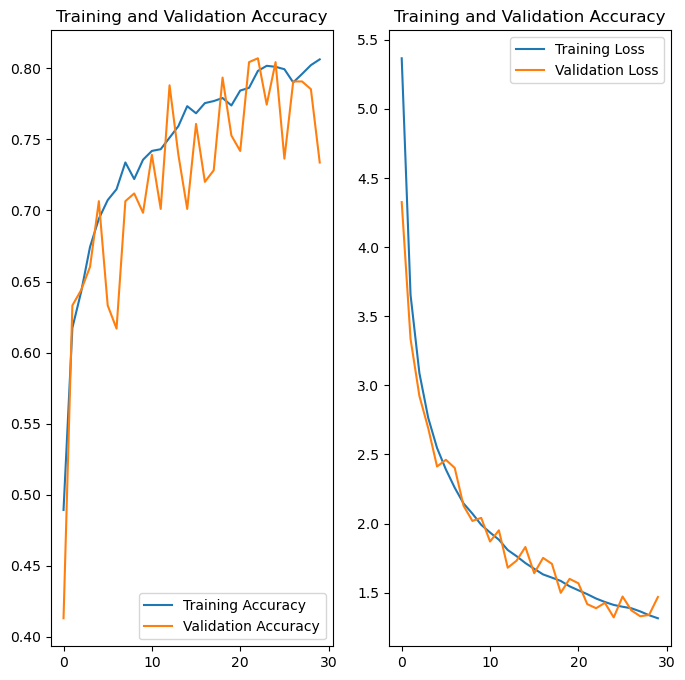

In [20]:
completed_epochs = len(history.history['accuracy'])

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(completed_epochs), acc, label='Training Accuracy')
plt.plot(range(completed_epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(completed_epochs), loss, label='Training Loss')
plt.plot(range(completed_epochs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')
plt.show()

In [76]:
scores = inception_model.evaluate(test_ds) # No Fine-Tuning

#Metrics
y_pred = inception_model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)
f1 = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
accuracy = accuracy_score(y_true, y_pred)
print(f'F1 Score: {f1}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'Accuracy: {accuracy}')
print(classification_report(y_true, y_pred))

4/4 [==============================] - 1s 207ms/step
F1 Score: 0.6288356511082694
Precision: 0.6288012289245841
Recall: 0.62890625
Accuracy: 0.62890625
              precision    recall  f1-score   support

           0       0.60      0.59      0.59        58
           1       0.70      0.70      0.70        60
           2       0.62      0.63      0.63        76
           3       0.60      0.60      0.60        62

    accuracy                           0.63       256
   macro avg       0.63      0.63      0.63       256
weighted avg       0.63      0.63      0.63       256



7/7 [==============================] - 1s 144ms/step


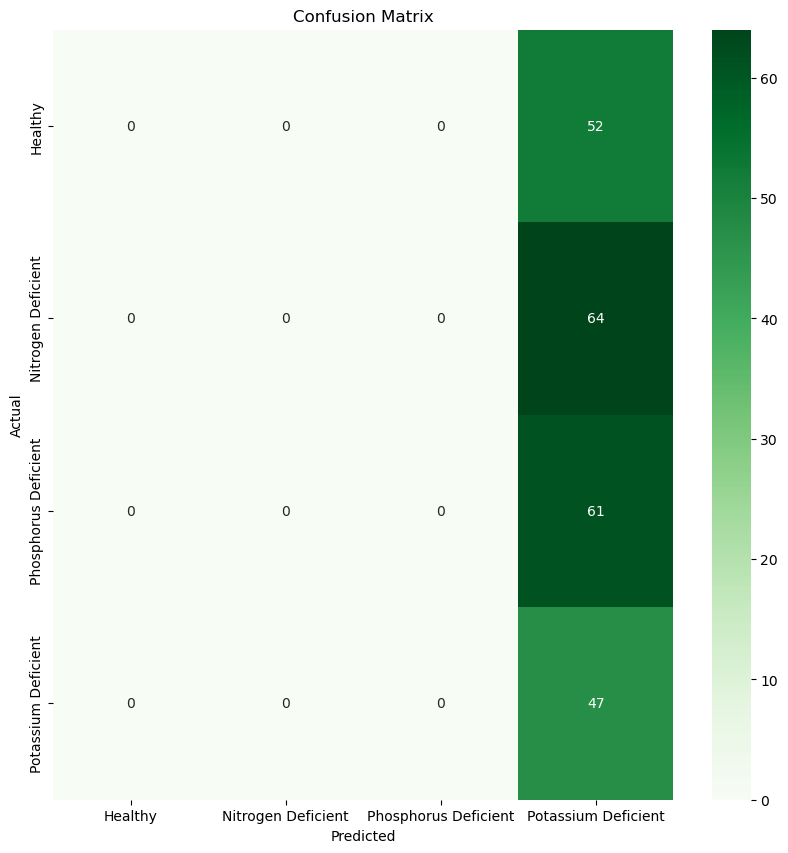

In [33]:
y_pred = inception_model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

1/1 [==============================] - 4s 4s/step
Predicted class: n deficiency
Confidence: 96.46%


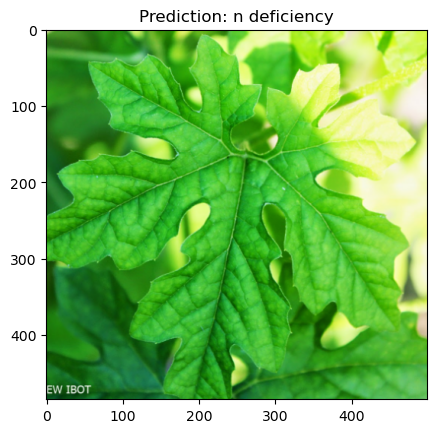

In [38]:
#code to predict from a folder
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Function to load and preprocess an image
def preprocess_image(img_path, target_size=(299, 299)):
    # Load image with the correct size for the model
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

# Predict function
def predict_image(img_path):
    # Preprocess the image
    img = preprocess_image(img_path)
    
    # Predict the class
    predictions = inception_model.predict(img)
    
    # Get the index of the highest probability class
    predicted_class = np.argmax(predictions[0])
    
    # Output the predicted class
    print(f"Predicted class: {class_names[predicted_class]}")
    print(f"Confidence: {np.max(predictions[0]) * 100:.2f}%")

    # Plot the image
    plt.imshow(image.load_img(img_path))
    plt.title(f"Prediction: {class_names[predicted_class]}")
    plt.show()

# Call the prediction function with your image
image_path = "C:/Users/REYES/OneDrive/Desktop/testing/7.jpg"
predict_image(image_path)


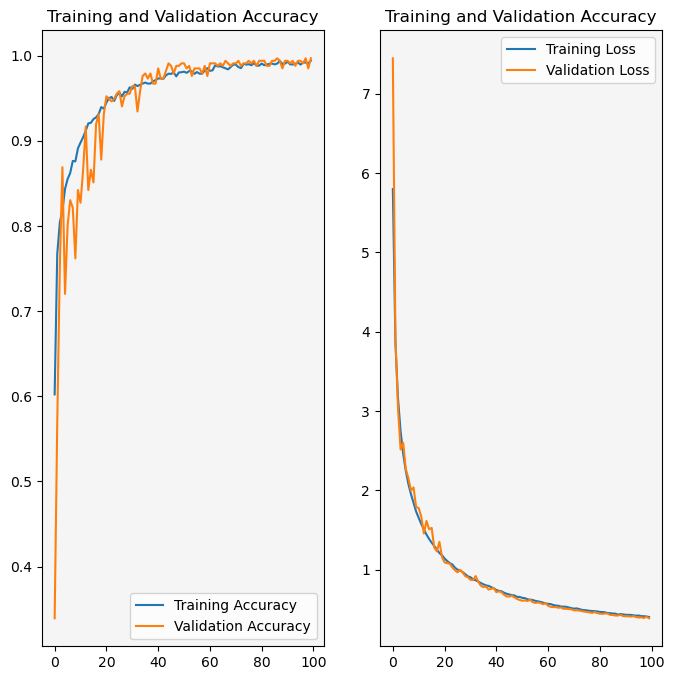

In [85]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
completed_epochs = len(history.history['accuracy'])

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(completed_epochs), acc, label='Training Accuracy')
plt.plot(range(completed_epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.grid(False)
plt.gca().set_facecolor('#F5F5F5')

plt.subplot(1, 2, 2)
plt.plot(range(completed_epochs), loss, label='Training Loss')
plt.plot(range(completed_epochs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')
plt.grid(False)
plt.gca().set_facecolor('#F5F5F5')
plt.show()

In [86]:
# Freeze all layers except the last 30 layers
for layer in base_model.layers[:-15]:
    layer.trainable = False

# Unfreeze the last 30 layers
for layer in base_model.layers[-15:]:
    layer.trainable = True

inception_model.compile(optimizer=Adam(learning_rate=0.0005), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

inception_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_15 (Dense)            (None, 512)               1049088   
                                                                 
 batch_normalization_290 (Ba  (None, 512)              2048      
 tchNormalization)                                               
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_16 (Dense)            (None, 512)               262656    
                                                      

In [87]:
history_finetune = inception_model.fit(
    train_ds,
    epochs=10,  # Additional epochs for fine-tuning
    batch_size = 64,
    validation_data=val_ds,
    callbacks=[stop_early, lr_scheduler]
)

Epoch 1/10
66/66 [==============================] - 33s 303ms/step - loss: 1.3441 - accuracy: 0.7071 - val_loss: 2.0428 - val_accuracy: 0.4702 - lr: 5.0000e-04
Epoch 2/10
66/66 [==============================] - 16s 242ms/step - loss: 0.8350 - accuracy: 0.8183 - val_loss: 1.7031 - val_accuracy: 0.5506 - lr: 5.0000e-04
Epoch 3/10
66/66 [==============================] - 16s 235ms/step - loss: 0.6947 - accuracy: 0.8692 - val_loss: 1.4395 - val_accuracy: 0.6369 - lr: 5.0000e-04
Epoch 4/10
66/66 [==============================] - 15s 233ms/step - loss: 0.6444 - accuracy: 0.8852 - val_loss: 0.9650 - val_accuracy: 0.7440 - lr: 5.0000e-04
Epoch 5/10
66/66 [==============================] - 16s 237ms/step - loss: 0.6062 - accuracy: 0.8934 - val_loss: 0.7802 - val_accuracy: 0.8423 - lr: 5.0000e-04
Epoch 6/10
66/66 [==============================] - 16s 239ms/step - loss: 0.5251 - accuracy: 0.9222 - val_loss: 0.6065 - val_accuracy: 0.8839 - lr: 5.0000e-04
Epoch 7/10
66/66 [======================

In [92]:
scores = inception_model.evaluate(test_ds) #No Fine-Tuning

#Metrics
y_pred = inception_model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)
f1 = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
accuracy = accuracy_score(y_true, y_pred)
print(f'F1 Score: {f1}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'Accuracy: {accuracy}')
print(classification_report(y_true, y_pred))

4/4 [==============================] - 1s 206ms/step
F1 Score: 0.6767647786032458
Precision: 0.6780762987012987
Recall: 0.6796875
Accuracy: 0.6796875
              precision    recall  f1-score   support

           0       0.64      0.55      0.59        58
           1       0.70      0.65      0.67        60
           2       0.69      0.80      0.74        76
           3       0.68      0.68      0.68        62

    accuracy                           0.68       256
   macro avg       0.68      0.67      0.67       256
weighted avg       0.68      0.68      0.68       256



4/4 [==============================] - 1s 206ms/step


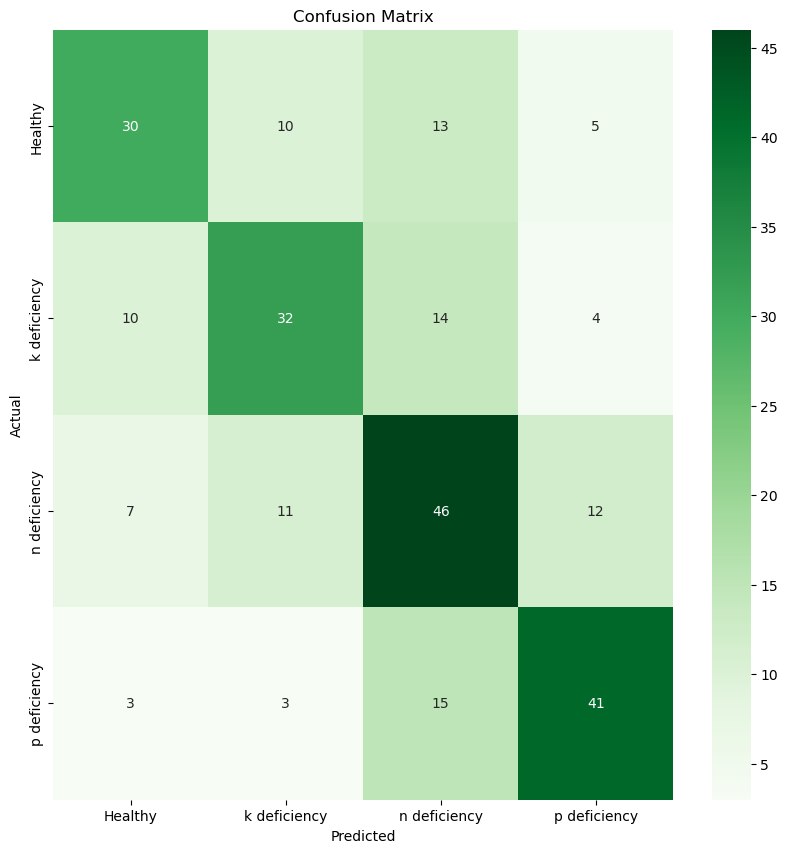

In [95]:
#Confusion Matrix
y_pred = inception_model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

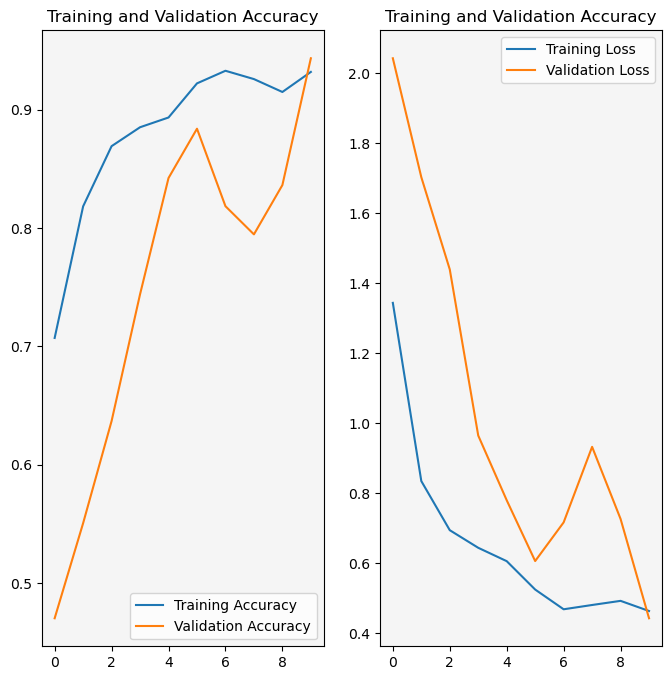

In [96]:
acc = history_finetune.history['accuracy']
val_acc = history_finetune.history['val_accuracy']

loss = history_finetune.history['loss']
val_loss = history_finetune.history['val_loss']
completed_epochs = len(history_finetune.history['accuracy'])

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(completed_epochs), acc, label='Training Accuracy')
plt.plot(range(completed_epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.grid(False)
plt.gca().set_facecolor('#F5F5F5')

plt.subplot(1, 2, 2)
plt.plot(range(completed_epochs), loss, label='Training Loss')
plt.plot(range(completed_epochs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')
plt.grid(False)
plt.gca().set_facecolor('#F5F5F5')
plt.show()

In [179]:
model_version = max([int(i) for i in os.listdir("../models") + [0]]) + 1
inception_model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/4\assets


INFO:tensorflow:Assets written to: ../models/4\assets


In [66]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) #Create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 35ms/step


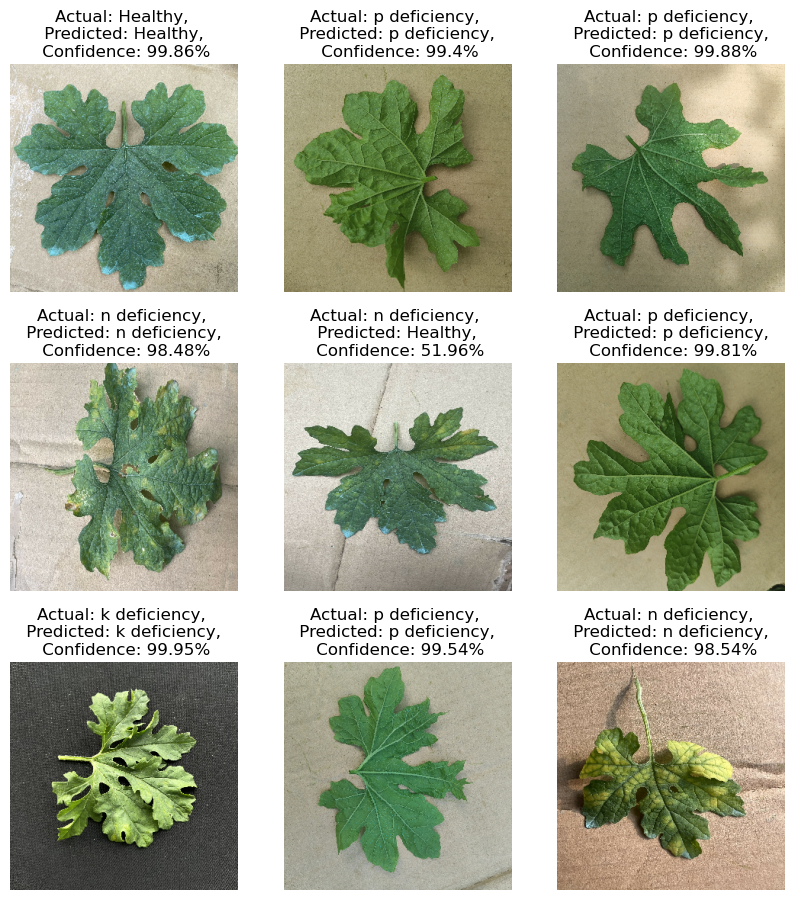

In [67]:
plt.figure(figsize=(10, 11))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class, confidence = predict(inception_model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}, \n Confidence: {confidence}%")
        
        plt.axis("off")